# DSB - MLOPS COURSE 

# 4 - Deployment

## 4.1 - Use case reminder and set up 

### Use Case

The project is *New York City Taxi trip duration prediction*. \
The goal is to use the available data in order to train a simple machine learning model
to predict the trip duration based on **some input that can be available in production environment**.

In this module, we will deploy one of the models we trained in the previous modules. The goal is to render it accessible for other developers via an API that we will develop. In order to do this, we will repeat the steps we have been performing so far. Namelly: 

- data processing
- model training

In [ ]:
from data_preprocessing import (
    filter_outliers,
    encode_categorical_cols,
    vectorize_dataframe,
)
from data_loading import load_data

from pathlib import Path
import pickle
from sklearn.linear_model import LinearRegression

ROOT_DIR = Path("..")

In [ ]:
train_df, _ = load_data(ROOT_DIR)

We will use the same data processing functions we used in the previous modules. 

In [ ]:
train_features, train_target, dict_vectorizer = (
    train_df.pipe(filter_outliers)
    .pipe(encode_categorical_cols)
    .pipe(vectorize_dataframe)
)

The model we will deploy is the linear regression we have implemented before. 

In [ ]:
model = LinearRegression()
model.fit(train_features, train_target)

In [ ]:
# save artifacts
with open(ROOT_DIR / "outputs/model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

with open(ROOT_DIR / "outputs/dict_vectorizer.pkl", "wb") as dict_vectorizer_file:
    pickle.dump(dict_vectorizer, dict_vectorizer_file)

## 4.2 - Model Deployment

Model deployment is the process of making a machine learning (ML) model accessible to users. It involves delegating the computing to an independent resource. This resource accepts requests from users and sends back responses, so that they can be used in real-world applications.


> There are three different types of deployment: 
- **Batch (offline)** : recurrent jobs that get automatically executed
- **Web Service (online)** : a server that awaits requests from clients and send back responses
- **Streaming (online)** : a consumer that awaits events from producers and triggers workflows

In this notebook, we will focus on **web service deployment**, which involves hosting the model on a server that is accessible over a network. This type of deployment is suitable for models that need to be used in real-time and for which batch processing is not feasible. 

### Imports

In [ ]:
from fastapi import FastAPI
import nest_asyncio
from pydantic import BaseModel
from pyngrok import ngrok
import uvicorn

### Create your Ngrok account 

In order to access your deployed API from any machine, your need it to be accessible via a public URL. Ngrok is a tool that allows you to assign public URLs to your APIs.

First, you'll need to sign up on Ngrok by creating an account, in order to retrieve an access key. To do so:
- Go to ngrok.com, and click on "Sign up"
- Follow the steps to create your account
- When your account is created, login to ngrok and go to "Getting Started > Your Authtoken"
- Copy your Authtoken and paste it in the following cell

You should now be able to access ngrok

In [ ]:
MY_AUTH_TOKEN = "..."  # Copy your Authtoken here

In [ ]:
ngrok.set_auth_token(MY_AUTH_TOKEN)

### Create your first API with FastAPI

A web service is essentially a server running on a computer device that listens for requests at a specific port over a network and serves web documents in response. This communication between the client and the server is typically done using the Hypertext Transfer Protocol (HTTP).

**HTTP** defines a set of request methods to indicate the desired action to be performed for a given resource. The two most commonly used methods are GET and POST:

- The **GET** method retrieves a representation of the specified resource
- The **POST** method submits an entity to the specified resource and often causes a change in state or side effects on the server

An **API**, or Application Programming Interface, determines the way in which the client communicates with the server. In short, it specifies the methods that are available to an user when making a request. 

> There are several frameworks that allow us to package our model into a web service:

- FastAPI
- Flask
- Django 
- BentoML

In this course, we will use FastAPI to deploy our model. 

> FastAPI is a framework that allows you to easily create and deploy APIs with few lines of code. 

[Documentation](https://fastapi.tiangolo.com/)

First, let's and instantiate our API object, the app:

In [ ]:
# Initiate the FastAPI app that will be run
app = FastAPI()

# Initiate the homepage of the API
@app.get("/")
def index():
    return {"message": "This is the homepage of the API "}

You can notice that FastAPI works with the decorator syntax. By using the `app` object, we can add request commands to our API. For that we just need to set a `path` as the argument of the decorator and a function that will compute the response to the request. 

Now that you initiated our app, you can execute the following cells to launch your app. You can copy the public ngrok address in your browser to explore your API. 

In [ ]:
ngrok_tunnel = ngrok.connect(8000)
print("Public URL:", ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, host="0.0.0.0", port=8000)

The `host` parameter tells our application to listen on the IP address `0.0.0.0`, which means any available network interface. Meanwhile the `port` parameter is specified to FastAPI's default `dev` port. 

If you want more information on the meaning of the parameters `host` and `port`, check: 
- [Meaning of port and host](https://stackoverflow.com/questions/1946193/whats-the-whole-point-of-localhost-hosts-and-ports-at-all)
- [Localhost vs. '0.0.0.0'](https://stackoverflow.com/questions/20778771/what-is-the-difference-between-0-0-0-0-127-0-0-1-and-localhost)

After clicking the link, you should encounter the following page: 

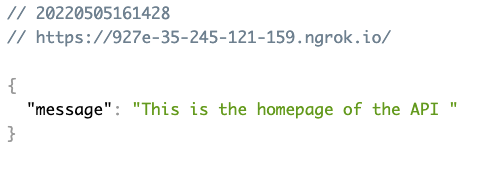

Your app is still empty at the moment, so we're going to fill it with functions !

### Implement model prediction in your app
We're going to create an app able to receive location IDs data from users, predict their trip time, and send back the prediction to the user. To do so, we need to implement two functions :
- A function that will load the model and the dictionary vectorizer
- A function that will perform predictions when it receives new data, and send it back to user

Start by implmenting the first function:

In [ ]:
##### Enter your code here #####
# Does the user of the API need to access the model and dict_vectorizer?
# If so, how can we make them available to the user?
# If not, how can we make them available to the other functions in the API?

- **Option 1** : Implement a simple function that loads the model and gets called later

In [ ]:
def load_model_and_dict_vectorizer():
    """Load the model and dict_vectorizer from the outputs folder.

    Returns:
        model, dict_vectorizer: The model and dict_vectorizer.
    """
    with open(ROOT_DIR / "outputs/model.pkl", "rb") as model_file:
        model = pickle.load(model_file)
    with open(ROOT_DIR / "outputs/dict_vectorizer.pkl", "rb") as dict_vectorizer_file:
        dict_vectorizer = pickle.load(dict_vectorizer_file)
    return model, dict_vectorizer

- **Option 2** : Load the model and dict vectorizer in the global namespace so that they are accessible to all functions in the API

In [ ]:
@app.on_event("startup")
def load_model_and_dict_vectorizer_bis():
    global model
    global dv
    with open(ROOT_DIR / "outputs/model.pkl", "rb") as model_file:
        model = pickle.load(model_file)
    with open(ROOT_DIR / "outputs/dict_vectorizer.pkl", "rb") as dict_vectorizer_file:
        dv = pickle.load(dict_vectorizer_file)

Then, you need to create a function that will receive your data, feed it to your model, and send back the predictions.

When building APIs, the format of data that gets sent to the server is a JSON format, which is easily translated to python dictionaries. 

One useful feature of FastAPI is that it performs automatic data validation using python's type hints. To do so, it uses the [pydantic](https://docs.pydantic.dev/usage/models/) package, which allows us to create `models` that enforce data structures in our code. 

Before implementing a `predict` function, think about the input you will receive and define a `BaseModel` that corresponds to it. 

In [ ]:
##### Enter your code here #####
# Do you expect a single value or a list of values?
# What are the names of the input variables?
# What are the types of the input variables? Are there any important constraints?

- **Option**:

In [ ]:
class Trip(BaseModel):
    PUlocationID: int
    DOlocationID: int

Finally, you need to create a function that will receive your data, feed it to your model, and send back the predictions.

In [ ]:
##### Enter your code here #####
# Should this be a GET or a POST request?
# What should be the format of the response?

- **Option** :

In [ ]:
@app.post("/predict")
def predict_trip_duration(data: Trip):
    model, dict_vectorizer = load_model_and_dict_vectorizer()

    input = dict_vectorizer.transform([data.dict()])
    prediction = model.predict(input).tolist()

    # Return predictions
    result = {"predicted_trip_duration": prediction}
    return result

### Run the app

Now that you app is ready, you can run it like earlier by executing following cell. 

Click on the given link to access your app homepage.

```
Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
```

As long as the cell keeps running, your server will be deployed and accessible.

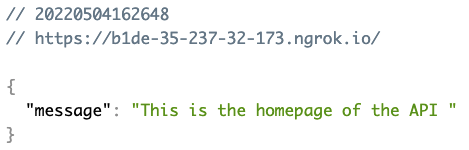


By adding "/docs" at the end of this URL, you'll then be redirected to a FastAPI page where you'll be able to test your app easily.

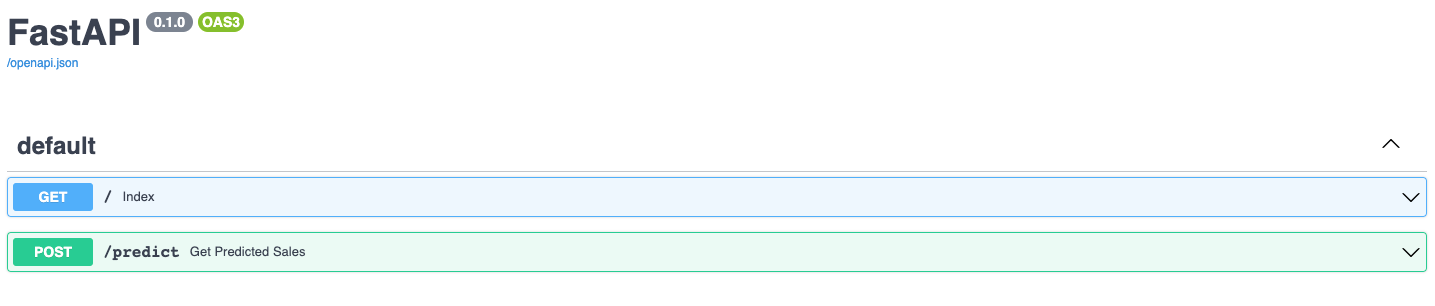

In [ ]:
ngrok_tunnel = ngrok.connect(8000)
print("Public URL:", ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, host="0.0.0.0", port=8000)

Click on the green "PREDICT" box, then "Try it out" to try your API

### Call the API from the internet

The whole purpose of creating such an API is to be able to access it from a remote location, and retrieve predictions quickly. Ngrok creates a tunnel from local to the internet, allowing you to request the API from any machine connected to the internet.


Whether it is from your machine on someone else's you can execute the following bash command (by replacing with the appropriate URL) on a terminal to send a request to the API:

``` shell
curl -X 'POST' \
  'http://your-ngrok-public-uri/predict' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
  "PUlocationID": 0,
  "DOlocationID": 0
}'
```

The result should look like the following: 

``` shell
{"predicted_trip_duration":[27.27173779352]}
```



# To go further:

- Can you implement a method that makes batch predictions, instead of single ones?
    - *TIP: you only need to modify the predict function*
- Can you implement an option to decide which version of the model we want to use to make predictions? 
    - *TIP: you can use [path parameters](https://fastapi.tiangolo.com/tutorial/path-params/)
- Can you integrate this section of the course with the previous ones? i.e. recover a model directly from MLFlow's model registry, orchestrate the training of the model using Prefect, ...

Note that in this demo we performed all operations from a Jupyter notebook to make the experience more interactive. In a real application, the API would be defined in a module and called either from the CLI or from a script. 
- Can you transpose all that we did in this notebok to python files and run the app using `uvicorn` CLI ? 